In [31]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

from timm import create_model


In [32]:
# ---- Update model + training hyperparameters ----
CONFIG = {
    "model_name": "swin_tiny_patch4_window7_224",  # backbone
    "img_size": 224,                               # Swin default
    "batch_size": 48,                              # optimized for 8GB VRAM
    "num_classes": 14,                             # NIH ChestX-ray14
    "num_epochs": 20,                              # sufficient for convergence
    "lr": 1.5e-4,                                  # tuned for larger batch
    "data_root": "data",                           # root folder containing images_001..012
    "train_split": "data/train_split.txt",
    "val_split": "data/val_split.txt",
    "test_split": "data/test_list.txt",
    "save_dir": "models/swin_transformer"
}

# ---- Create save directory if missing ----
os.makedirs(CONFIG["save_dir"], exist_ok=True)


In [33]:
# Load metadata
df = pd.read_csv("Data_Entry_2017.csv")

# Define 14 disease class names
class_names = [
    "Atelectasis", "Cardiomegaly", "Effusion", "Infiltration",
    "Mass", "Nodule", "Pneumonia", "Pneumothorax",
    "Consolidation", "Edema", "Emphysema", "Fibrosis",
    "Pleural_Thickening", "Hernia"
]

# Load split lists
with open(CONFIG["train_split"], "r") as f:
    train_files = set(line.strip() for line in f)
with open(CONFIG["val_split"], "r") as f:
    val_files = set(line.strip() for line in f)
with open(CONFIG["test_split"], "r") as f:
    test_files = set(line.strip() for line in f)

# Filter DataFrames
train_df = df[df["Image Index"].isin(train_files)].reset_index(drop=True)
val_df = df[df["Image Index"].isin(val_files)].reset_index(drop=True)
test_df = df[df["Image Index"].isin(test_files)].reset_index(drop=True)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 77871 | Val: 8653 | Test: 25596


In [34]:
train_transform = A.Compose([
    A.Resize(CONFIG["img_size"], CONFIG["img_size"]),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(CONFIG["img_size"], CONFIG["img_size"]),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


/home/prem/PROJECT DATA/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [35]:
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, data_root, transform=None):
        self.df = dataframe
        self.data_root = data_root
        self.transform = transform

    def find_image_path(self, img_name):
    # Search inside images_001/images/, images_002/images/, ..., images_012/images/
        for i in range(1, 13):
            img_path = os.path.join(self.data_root, f"images_{i:03d}", "images", img_name)
            if os.path.exists(img_path):
                return img_path
        raise FileNotFoundError(f"{img_name} not found in any images_00X/images/ folder")


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["Image Index"]
        img_path = self.find_image_path(img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        labels = row["Finding Labels"].split('|')
        target = np.zeros(len(class_names), dtype=np.float32)
        for label in labels:
            if label in class_names:
                target[class_names.index(label)] = 1.0

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, torch.tensor(target)


In [36]:
train_dataset = ChestXrayDataset(train_df, CONFIG["data_root"], transform=train_transform)
val_dataset = ChestXrayDataset(val_df, CONFIG["data_root"], transform=val_transform)
test_dataset = ChestXrayDataset(test_df, CONFIG["data_root"], transform=val_transform)

# Optimized DataLoader setup for Linux + RTX 4060 (8 GB VRAM)
num_workers = 8  # all logical CPU cores if available

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],   # e.g., 48
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,                   # speeds up host-to-GPU transfer
    persistent_workers=True            # keeps workers alive between epochs
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Data ready — Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")



✅ Data ready — Train: 1623 | Val: 181 | Test: 534


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = create_model(CONFIG["model_name"], pretrained=True, num_classes=CONFIG["num_classes"])
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG["lr"])


Using device: cuda


In [38]:
best_auc = 0.0
best_f1 = 0.0
best_overall = 0.0

for epoch in range(CONFIG["num_epochs"]):
    model.train()
    train_loss = 0.0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # === Validation ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = torch.sigmoid(model(imgs))
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    aurocs, f1s = [], []
    for i in range(CONFIG["num_classes"]):
        if y_true[:, i].sum() > 0:
            aurocs.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
            f1s.append(f1_score(y_true[:, i], (y_pred[:, i] > 0.5).astype(int)))

    mean_auc = np.mean(aurocs)
    mean_f1 = np.mean(f1s)
    mean_overall = (mean_auc + mean_f1) / 2

    print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | "
          f"AUC: {mean_auc:.4f} | F1: {mean_f1:.4f} | Combo: {mean_overall:.4f}")

    # === Save checkpoints ===
    if mean_auc > best_auc:
        best_auc = mean_auc
        torch.save(model.state_dict(), os.path.join(CONFIG["save_dir"], "swin_best_auroc.pth"))
        print(f"✅ Saved best AUROC model: {best_auc:.4f}")

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        torch.save(model.state_dict(), os.path.join(CONFIG["save_dir"], "swin_best_f1.pth"))
        print(f"✅ Saved best F1 model: {best_f1:.4f}")

    if mean_overall > best_overall:
        best_overall = mean_overall
        torch.save(model.state_dict(), os.path.join(CONFIG["save_dir"], "swin_best_overall.pth"))
        print(f"✅ Saved best OVERALL model: {best_overall:.4f}")


Epoch 1/20: 100%|██████████| 1623/1623 [12:28<00:00,  2.17it/s]


Epoch 1 | Loss: 0.1510 | AUC: 0.7319 | F1: 0.0148 | Combo: 0.3734
✅ Saved best AUROC model: 0.7319
✅ Saved best F1 model: 0.0148
✅ Saved best OVERALL model: 0.3734


Epoch 2/20: 100%|██████████| 1623/1623 [10:36<00:00,  2.55it/s]


Epoch 2 | Loss: 0.1634 | AUC: 0.5224 | F1: 0.0000 | Combo: 0.2612


Epoch 3/20: 100%|██████████| 1623/1623 [10:36<00:00,  2.55it/s]


Epoch 3 | Loss: 0.1635 | AUC: 0.5309 | F1: 0.0000 | Combo: 0.2654


Epoch 4/20: 100%|██████████| 1623/1623 [10:38<00:00,  2.54it/s]


Epoch 4 | Loss: 0.1618 | AUC: 0.5868 | F1: 0.0000 | Combo: 0.2934


Epoch 5/20: 100%|██████████| 1623/1623 [10:38<00:00,  2.54it/s]


Epoch 5 | Loss: 0.1563 | AUC: 0.6877 | F1: 0.0042 | Combo: 0.3459


Epoch 6/20: 100%|██████████| 1623/1623 [10:37<00:00,  2.54it/s]


Epoch 6 | Loss: 0.1500 | AUC: 0.7175 | F1: 0.0156 | Combo: 0.3665
✅ Saved best F1 model: 0.0156


Epoch 7/20: 100%|██████████| 1623/1623 [10:36<00:00,  2.55it/s]


Epoch 7 | Loss: 0.1445 | AUC: 0.7803 | F1: 0.0204 | Combo: 0.4003
✅ Saved best AUROC model: 0.7803
✅ Saved best F1 model: 0.0204
✅ Saved best OVERALL model: 0.4003


Epoch 8/20: 100%|██████████| 1623/1623 [10:36<00:00,  2.55it/s]


Epoch 8 | Loss: 0.1401 | AUC: 0.7901 | F1: 0.0565 | Combo: 0.4233
✅ Saved best AUROC model: 0.7901
✅ Saved best F1 model: 0.0565
✅ Saved best OVERALL model: 0.4233


Epoch 9/20: 100%|██████████| 1623/1623 [14:54<00:00,  1.81it/s]


Epoch 9 | Loss: 0.1371 | AUC: 0.8103 | F1: 0.0852 | Combo: 0.4477
✅ Saved best AUROC model: 0.8103
✅ Saved best F1 model: 0.0852
✅ Saved best OVERALL model: 0.4477


Epoch 10/20: 100%|██████████| 1623/1623 [10:36<00:00,  2.55it/s]


Epoch 10 | Loss: 0.1348 | AUC: 0.8079 | F1: 0.0678 | Combo: 0.4378


Epoch 11/20: 100%|██████████| 1623/1623 [10:32<00:00,  2.56it/s]


Epoch 11 | Loss: 0.1331 | AUC: 0.8156 | F1: 0.0726 | Combo: 0.4441
✅ Saved best AUROC model: 0.8156


Epoch 12/20: 100%|██████████| 1623/1623 [10:32<00:00,  2.57it/s]


Epoch 12 | Loss: 0.1315 | AUC: 0.8118 | F1: 0.0909 | Combo: 0.4514
✅ Saved best F1 model: 0.0909
✅ Saved best OVERALL model: 0.4514


Epoch 13/20: 100%|██████████| 1623/1623 [10:33<00:00,  2.56it/s]


Epoch 13 | Loss: 0.1297 | AUC: 0.8214 | F1: 0.1323 | Combo: 0.4768
✅ Saved best AUROC model: 0.8214
✅ Saved best F1 model: 0.1323
✅ Saved best OVERALL model: 0.4768


Epoch 14/20: 100%|██████████| 1623/1623 [10:34<00:00,  2.56it/s]


Epoch 14 | Loss: 0.1279 | AUC: 0.8180 | F1: 0.1333 | Combo: 0.4756
✅ Saved best F1 model: 0.1333


Epoch 15/20: 100%|██████████| 1623/1623 [10:33<00:00,  2.56it/s]


Epoch 15 | Loss: 0.1265 | AUC: 0.8213 | F1: 0.1184 | Combo: 0.4699


Epoch 16/20: 100%|██████████| 1623/1623 [10:32<00:00,  2.56it/s]


Epoch 16 | Loss: 0.1246 | AUC: 0.8291 | F1: 0.1301 | Combo: 0.4796
✅ Saved best AUROC model: 0.8291
✅ Saved best OVERALL model: 0.4796


Epoch 17/20: 100%|██████████| 1623/1623 [10:33<00:00,  2.56it/s]


Epoch 17 | Loss: 0.1230 | AUC: 0.8136 | F1: 0.1212 | Combo: 0.4674


Epoch 18/20: 100%|██████████| 1623/1623 [10:32<00:00,  2.57it/s]


Epoch 18 | Loss: 0.1214 | AUC: 0.8182 | F1: 0.1699 | Combo: 0.4940
✅ Saved best F1 model: 0.1699
✅ Saved best OVERALL model: 0.4940


Epoch 19/20: 100%|██████████| 1623/1623 [10:32<00:00,  2.57it/s]


Epoch 19 | Loss: 0.1196 | AUC: 0.8238 | F1: 0.1729 | Combo: 0.4984
✅ Saved best F1 model: 0.1729
✅ Saved best OVERALL model: 0.4984


Epoch 20/20: 100%|██████████| 1623/1623 [10:32<00:00,  2.56it/s]


Epoch 20 | Loss: 0.1174 | AUC: 0.8236 | F1: 0.1675 | Combo: 0.4956


In [39]:
# ==============================================
# RESUME TRAINING (30 more epochs with patience=7)
# ==============================================

import torch
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score, f1_score
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import os
from tqdm import tqdm

# ----- Load best checkpoint -----
resume_path = os.path.join(CONFIG["save_dir"], "swin_best_overall.pth")
model.load_state_dict(torch.load(resume_path))
model = model.to(device)
model.train()

# ----- Optimizer + scheduler -----
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["lr"] * 0.5, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

# ----- AMP scaler -----
scaler = GradScaler()

# ----- Early stopping parameters -----
max_epochs = 30
patience = 7
best_overall = 0.0
epochs_no_improve = 0

print(f"Resuming fine-tuning for {max_epochs} epochs with early stopping (patience={patience})...")

for epoch in range(1, max_epochs + 1):
    model.train()
    running_loss = 0.0

    # ---------- Training ----------
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    scheduler.step()

    # ---------- Validation ----------
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = torch.sigmoid(model(imgs))
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    aurocs, f1s = [], []
    for i in range(CONFIG["num_classes"]):
        if y_true[:, i].sum() > 0:
            aurocs.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
            f1s.append(f1_score(y_true[:, i], (y_pred[:, i] > 0.5).astype(int)))

    mean_auc = np.mean(aurocs)
    mean_f1 = np.mean(f1s)
    mean_overall = (mean_auc + mean_f1) / 2

    print(f"📊 Epoch {epoch}: Loss {running_loss/len(train_loader):.4f} | "
          f"Val AUC {mean_auc:.4f} | Val F1 {mean_f1:.4f} | Combo {mean_overall:.4f}")

    # ---------- Early stopping & checkpointing ----------
    if mean_overall > best_overall:
        best_overall = mean_overall
        epochs_no_improve = 0
        ckpt_path = os.path.join(CONFIG["save_dir"], f"swin_best_overall_epoch{epoch}.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Improvement detected. Saved: {ckpt_path}")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print(f"⏹ Early stopping triggered at epoch {epoch}. Best overall score: {best_overall:.4f}")
        break

print("🏁 Training complete.")


/tmp/ipykernel_6524/1189400267.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(resume_path))
/tmp/ipykernel_6524/1189400267.py:24: Futu

Resuming fine-tuning for 30 epochs with early stopping (patience=7)...


Epoch 1/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 1623/1623 [05:42<00:00,  4.74it/s]


📊 Epoch 1: Loss 0.1122 | Val AUC 0.8200 | Val F1 0.1758 | Combo 0.4979
✅ Improvement detected. Saved: models/swin_transformer/swin_best_overall_epoch1.pth


Epoch 2/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/30: 100%|██████████| 1623/1623 [05:40<00:00,  4.76it/s]


📊 Epoch 2: Loss 0.1084 | Val AUC 0.8217 | Val F1 0.1831 | Combo 0.5024
✅ Improvement detected. Saved: models/swin_transformer/swin_best_overall_epoch2.pth


Epoch 3/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 3: Loss 0.1049 | Val AUC 0.8183 | Val F1 0.1927 | Combo 0.5055
✅ Improvement detected. Saved: models/swin_transformer/swin_best_overall_epoch3.pth


Epoch 4/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 4: Loss 0.1017 | Val AUC 0.8159 | Val F1 0.2027 | Combo 0.5093
✅ Improvement detected. Saved: models/swin_transformer/swin_best_overall_epoch4.pth


Epoch 5/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 5: Loss 0.0984 | Val AUC 0.8156 | Val F1 0.2122 | Combo 0.5139
✅ Improvement detected. Saved: models/swin_transformer/swin_best_overall_epoch5.pth


Epoch 6/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 6: Loss 0.0954 | Val AUC 0.8136 | Val F1 0.1860 | Combo 0.4998
⚠️ No improvement for 1 epochs.


Epoch 7/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 7: Loss 0.0927 | Val AUC 0.8029 | Val F1 0.2094 | Combo 0.5061
⚠️ No improvement for 2 epochs.


Epoch 8/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 8: Loss 0.0890 | Val AUC 0.8032 | Val F1 0.2019 | Combo 0.5026
⚠️ No improvement for 3 epochs.


Epoch 9/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 9: Loss 0.0863 | Val AUC 0.8035 | Val F1 0.2253 | Combo 0.5144
✅ Improvement detected. Saved: models/swin_transformer/swin_best_overall_epoch9.pth


Epoch 10/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/30: 100%|██████████| 1623/1623 [05:40<00:00,  4.76it/s]


📊 Epoch 10: Loss 0.0819 | Val AUC 0.7999 | Val F1 0.2038 | Combo 0.5018
⚠️ No improvement for 1 epochs.


Epoch 11/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/30: 100%|██████████| 1623/1623 [05:40<00:00,  4.76it/s]


📊 Epoch 11: Loss 0.0788 | Val AUC 0.7958 | Val F1 0.2038 | Combo 0.4998
⚠️ No improvement for 2 epochs.


Epoch 12/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 12: Loss 0.0770 | Val AUC 0.7941 | Val F1 0.2070 | Combo 0.5005
⚠️ No improvement for 3 epochs.


Epoch 13/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 13: Loss 0.0725 | Val AUC 0.7918 | Val F1 0.1955 | Combo 0.4937
⚠️ No improvement for 4 epochs.


Epoch 14/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/30: 100%|██████████| 1623/1623 [05:40<00:00,  4.76it/s]


📊 Epoch 14: Loss 0.0702 | Val AUC 0.7864 | Val F1 0.2044 | Combo 0.4954
⚠️ No improvement for 5 epochs.


Epoch 15/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.76it/s]


📊 Epoch 15: Loss 0.0673 | Val AUC 0.7806 | Val F1 0.2054 | Combo 0.4930
⚠️ No improvement for 6 epochs.


Epoch 16/30:   0%|          | 0/1623 [00:00<?, ?it/s]/tmp/ipykernel_6524/1189400267.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/30: 100%|██████████| 1623/1623 [05:41<00:00,  4.75it/s]


📊 Epoch 16: Loss 0.0642 | Val AUC 0.7785 | Val F1 0.2181 | Combo 0.4983
⚠️ No improvement for 7 epochs.
⏹ Early stopping triggered at epoch 16. Best overall score: 0.5144
🏁 Training complete.


In [40]:
# ==============================================
# PERFORMANCE EVALUATION MATRIX (Validation or Test)
# ==============================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
)
import torch
from tqdm import tqdm

# --- Load best checkpoint automatically (latest .pth in save_dir) ---
best_model_path = sorted(
    [p for p in os.listdir(CONFIG["save_dir"]) if p.endswith(".pth")],
    key=lambda x: os.path.getmtime(os.path.join(CONFIG["save_dir"], x))
)[-1]

model.load_state_dict(torch.load(os.path.join(CONFIG["save_dir"], best_model_path)))
model = model.to(device)
model.eval()

print(f"✅ Loaded checkpoint: {best_model_path}")

# --- Choose which loader to evaluate ---
loader = test_loader  # 👈 change to val_loader if you want validation metrics

# --- Collect predictions and labels ---
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(loader, desc="Evaluating"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(imgs))
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# --- Compute per-class metrics ---
results = []
for i, cls in enumerate(class_names):
    if y_true[:, i].sum() == 0:
        continue
    auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    preds_binary = (y_pred[:, i] > 0.5).astype(int)
    acc = accuracy_score(y_true[:, i], preds_binary)
    f1 = f1_score(y_true[:, i], preds_binary)
    prec = precision_score(y_true[:, i], preds_binary, zero_division=0)
    rec = recall_score(y_true[:, i], preds_binary)
    results.append({
        "Class": cls,
        "AUROC": auc,
        "Accuracy": acc,
        "F1-Score": f1,
        "Precision": prec,
        "Recall": rec
    })

# --- Convert to DataFrame and show results ---
df_results = pd.DataFrame(results)
df_results.loc["Macro Avg"] = df_results.mean(numeric_only=True)
df_results.loc["Macro Avg", "Class"] = "Macro Average"

pd.set_option("display.precision", 4)
display(df_results)

print("\n📊 Macro AUROC:", round(df_results.loc["Macro Avg", "AUROC"], 4))
print("📊 Macro F1:", round(df_results.loc["Macro Avg", "F1-Score"], 4))
print("📊 Macro Accuracy:", round(df_results.loc["Macro Avg", "Accuracy"], 4))


/tmp/ipykernel_6524/2817239397.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CONFIG["save_dir"], best_model_path)))


✅ Loaded checkpoint: swin_best_overall_epoch9.pth


Evaluating: 100%|██████████| 534/534 [01:09<00:00,  7.65it/s]


,Class,AUROC,Accuracy,F1-Score,Precision,Recall
0,Atelectasis,0.7202,0.8456,0.2754,0.3454,0.2290
1,Cardiomegaly,0.8440,0.9530,0.2724,0.3859,0.2105
2,Effusion,0.7782,0.8168,0.4251,0.4957,0.3720
3,Infiltration,0.6648,0.7343,0.3492,0.4206,0.2986
4,Mass,0.7601,0.9241,0.2598,0.3888,0.1951
5,Nodule,0.7091,0.9268,0.2047,0.3292,0.1485
6,Pneumonia,0.6818,0.9778,0.0035,0.0667,0.0018
7,Pneumothorax,0.8200,0.8919,0.3387,0.4661,0.2660
8,Consolidation,0.7152,0.9146,0.0959,0.1924,0.0639
9,Edema,0.8016,0.9571,0.1257,0.2380,0.0854



📊 Macro AUROC: 0.7637
📊 Macro F1: 0.2106
📊 Macro Accuracy: 0.9155


In [41]:
# ==========================================
# COMPARE BEST AUROC MODEL vs BEST OVERALL MODEL
# ==========================================
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm
import os

def evaluate_checkpoint(ckpt_path, loader):
    """
    Evaluate a single checkpoint and return (mean AUROC, mean F1)
    """
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Evaluating {os.path.basename(ckpt_path)}"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = torch.sigmoid(model(imgs))
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    aurocs, f1s = [], []
    for i in range(CONFIG["num_classes"]):
        if y_true[:, i].sum() == 0:
            continue
        aurocs.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
        f1s.append(f1_score(y_true[:, i], (y_pred[:, i] > 0.5).astype(int)))

    return np.mean(aurocs), np.mean(f1s)


# --- Paths to checkpoints ---
ckpt_auroc = os.path.join(CONFIG["save_dir"], "swin_best_auroc.pth")
ckpt_overall = os.path.join(CONFIG["save_dir"], "swin_best_overall.pth")

# --- Choose evaluation set ---
loader = val_loader   # 👈 change to test_loader to compare on test set

# --- Evaluate both models ---
auc_1, f1_1 = evaluate_checkpoint(ckpt_auroc, loader)
auc_2, f1_2 = evaluate_checkpoint(ckpt_overall, loader)

# --- Display comparison ---
print("\n📊 Model Performance Comparison")
print("────────────────────────────────────────────")
print(f"✅ Best AUROC Model   | AUROC: {auc_1:.4f} | F1: {f1_1:.4f}")
print(f"✅ Best OVERALL Model | AUROC: {auc_2:.4f} | F1: {f1_2:.4f}")
print("────────────────────────────────────────────")

# --- Optional: decide which model is better overall ---
if auc_1 > auc_2:
    print(f"🏁 Best AUROC model ({auc_1:.4f}) has stronger discrimination.")
else:
    print(f"🏁 Best OVERALL model ({auc_2:.4f}) generalizes better.")


/tmp/ipykernel_6524/2902339424.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path))
Evaluating swin_best_auroc.pth: 100%|███████


📊 Model Performance Comparison
────────────────────────────────────────────
✅ Best AUROC Model   | AUROC: 0.8291 | F1: 0.1301
✅ Best OVERALL Model | AUROC: 0.8238 | F1: 0.1729
────────────────────────────────────────────
🏁 Best AUROC model (0.8291) has stronger discrimination.


🧩 Found 9 checkpoints to compare:
    swin_best_auroc.pth
    swin_best_f1.pth
    swin_best_overall.pth
    swin_best_overall_epoch1.pth
    swin_best_overall_epoch2.pth
    swin_best_overall_epoch3.pth
    swin_best_overall_epoch4.pth
    swin_best_overall_epoch5.pth
    swin_best_overall_epoch9.pth


/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path))
Evaluating swin_best_auroc.pth: 100%|████████


✅ swin_best_auroc.pth | Macro AUROC: 0.8291 | Macro F1: 0.1301


Evaluating swin_best_f1.pth: 100%|██████████| 181/181 [00:23<00:00,  7.60it/s]
/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_


✅ swin_best_f1.pth | Macro AUROC: 0.8238 | Macro F1: 0.1729


Evaluating swin_best_overall.pth: 100%|██████████| 181/181 [00:24<00:00,  7.53it/s]
/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.


✅ swin_best_overall.pth | Macro AUROC: 0.8238 | Macro F1: 0.1729


Evaluating swin_best_overall_epoch1.pth: 100%|██████████| 181/181 [00:24<00:00,  7.37it/s]
/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 


✅ swin_best_overall_epoch1.pth | Macro AUROC: 0.8200 | Macro F1: 0.1758


Evaluating swin_best_overall_epoch2.pth: 100%|██████████| 181/181 [00:24<00:00,  7.34it/s]
/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 


✅ swin_best_overall_epoch2.pth | Macro AUROC: 0.8217 | Macro F1: 0.1831


Evaluating swin_best_overall_epoch3.pth: 100%|██████████| 181/181 [00:24<00:00,  7.28it/s]
/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 


✅ swin_best_overall_epoch3.pth | Macro AUROC: 0.8183 | Macro F1: 0.1927


Evaluating swin_best_overall_epoch4.pth: 100%|██████████| 181/181 [00:24<00:00,  7.29it/s]
/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 


✅ swin_best_overall_epoch4.pth | Macro AUROC: 0.8159 | Macro F1: 0.2027


Evaluating swin_best_overall_epoch5.pth: 100%|██████████| 181/181 [00:24<00:00,  7.24it/s]
/tmp/ipykernel_6524/411093097.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 


✅ swin_best_overall_epoch5.pth | Macro AUROC: 0.8156 | Macro F1: 0.2122


Evaluating swin_best_overall_epoch9.pth: 100%|██████████| 181/181 [00:25<00:00,  7.22it/s]



✅ swin_best_overall_epoch9.pth | Macro AUROC: 0.8035 | Macro F1: 0.2253

📊 Summary of All Models:


,Checkpoint,Macro AUROC,Macro F1
0,swin_best_auroc.pth,0.8291,0.1301
1,swin_best_f1.pth,0.8238,0.1729
2,swin_best_overall.pth,0.8238,0.1729
3,swin_best_overall_epoch2.pth,0.8217,0.1831
4,swin_best_overall_epoch1.pth,0.8200,0.1758
5,swin_best_overall_epoch3.pth,0.8183,0.1927
6,swin_best_overall_epoch4.pth,0.8159,0.2027
7,swin_best_overall_epoch5.pth,0.8156,0.2122
8,swin_best_overall_epoch9.pth,0.8035,0.2253


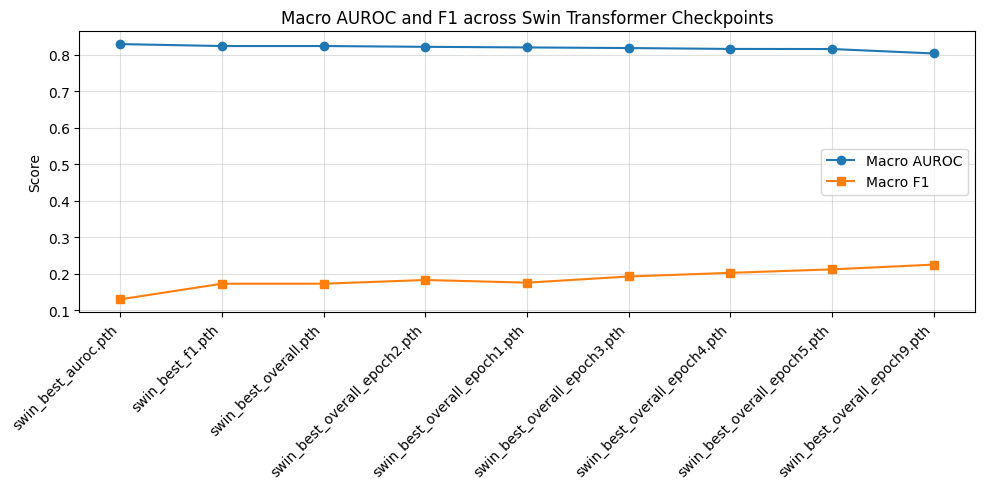

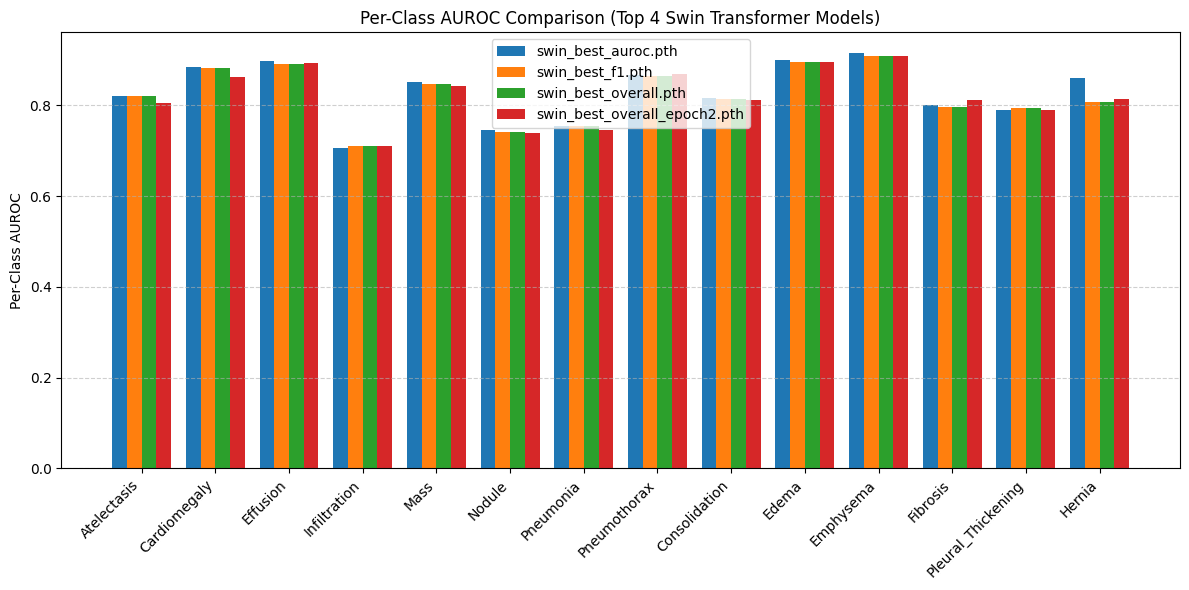

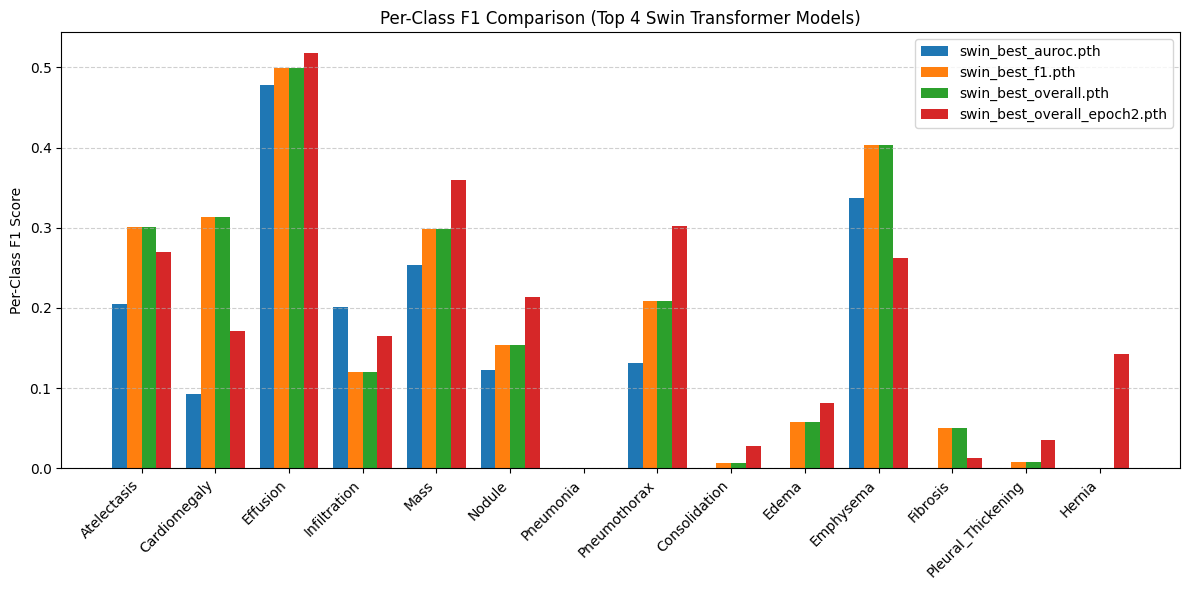

In [42]:
# ===============================================================
# FULL COMPARISON: ALL SWIN TRANSFORMER CHECKPOINTS (AUROC + F1)
# ===============================================================
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os

# ---------- Evaluation Function ----------
def evaluate_checkpoint(ckpt_path, loader):
    """Evaluate a checkpoint and return per-class AUROC, F1, and macro metrics"""
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=f"Evaluating {os.path.basename(ckpt_path)}"):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = torch.sigmoid(model(imgs))
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    aurocs, f1s = [], []
    for i in range(CONFIG["num_classes"]):
        if y_true[:, i].sum() == 0:
            aurocs.append(0)
            f1s.append(0)
        else:
            aurocs.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
            f1s.append(f1_score(y_true[:, i], (y_pred[:, i] > 0.5).astype(int)))

    return np.array(aurocs), np.array(f1s), np.mean(aurocs), np.mean(f1s)


# ---------- Collect All Checkpoints ----------
folder = CONFIG["save_dir"]
all_ckpts = [
    "swin_best_auroc.pth",
    "swin_best_f1.pth",
    "swin_best_overall.pth"
]
# Include epoch-based overall checkpoints if they exist
epoch_ckpts = sorted([f for f in os.listdir(folder) if "swin_best_overall_epoch" in f])
all_ckpts.extend(epoch_ckpts)

print(f"🧩 Found {len(all_ckpts)} checkpoints to compare:")
for c in all_ckpts:
    print("   ", c)

# ---------- Choose Evaluation Loader ----------
loader = val_loader   # 👈 change to test_loader for test evaluation

# ---------- Evaluate All Models ----------
results = {}
for ckpt in all_ckpts:
    aucs, f1s, macro_auc, macro_f1 = evaluate_checkpoint(os.path.join(folder, ckpt), loader)
    results[ckpt] = {"aucs": aucs, "f1s": f1s, "macro_auc": macro_auc, "macro_f1": macro_f1}
    print(f"\n✅ {ckpt} | Macro AUROC: {macro_auc:.4f} | Macro F1: {macro_f1:.4f}")

# ---------- Summary Table ----------
df_summary = pd.DataFrame({
    "Checkpoint": list(results.keys()),
    "Macro AUROC": [results[k]["macro_auc"] for k in results],
    "Macro F1": [results[k]["macro_f1"] for k in results]
}).sort_values(by="Macro AUROC", ascending=False).reset_index(drop=True)

print("\n📊 Summary of All Models:")
display(df_summary)

# ---------- Visualization: Macro AUROC + F1 ----------
plt.figure(figsize=(10, 5))
plt.plot(df_summary["Checkpoint"], df_summary["Macro AUROC"], 'o-', label="Macro AUROC")
plt.plot(df_summary["Checkpoint"], df_summary["Macro F1"], 's-', label="Macro F1")
plt.xticks(rotation=45, ha='right')
plt.title("Macro AUROC and F1 across Swin Transformer Checkpoints")
plt.ylabel("Score")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Per-Class AUROC Comparison (Top 4 models only for clarity) ----------
top_models = df_summary["Checkpoint"][:4]
x = np.arange(len(class_names))
width = 0.2

plt.figure(figsize=(12,6))
for i, ckpt in enumerate(top_models):
    plt.bar(x + (i - 1.5) * width, results[ckpt]["aucs"], width, label=ckpt)
plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel("Per-Class AUROC")
plt.title("Per-Class AUROC Comparison (Top 4 Swin Transformer Models)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ---------- Per-Class F1 Comparison (Top 4 models only) ----------
plt.figure(figsize=(12,6))
for i, ckpt in enumerate(top_models):
    plt.bar(x + (i - 1.5) * width, results[ckpt]["f1s"], width, label=ckpt)
plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel("Per-Class F1 Score")
plt.title("Per-Class F1 Comparison (Top 4 Swin Transformer Models)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [50]:
import torch
import numpy as np

# If Swin outputs are logits, apply sigmoid manually
if preds_swin.max() > 1.0:
    preds_swin = torch.sigmoid(torch.tensor(preds_swin)).numpy()
else:
    preds_swin = np.clip(preds_swin, 0, 1)

print("✅ Swin Transformer predictions normalized.")
print(f"Range after fix: min={preds_swin.min():.3f}, max={preds_swin.max():.3f}, mean={preds_swin.mean():.3f}")


✅ Swin Transformer predictions normalized.
Range after fix: min=0.000, max=0.969, mean=0.069


In [44]:
# ========================================================
# FINAL 4-MODEL ENSEMBLE (Swin + EffNet-B3 + EffNet-B4 + DenseNet)
# ========================================================
import timm
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_name, ckpt_path, num_classes=14):
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    checkpoint = torch.load(ckpt_path, map_location=device)

    # If checkpoint contains extra keys (like optimizer, epoch)
    if "model_state_dict" in checkpoint:
        print(f"🔍 Loading model weights from 'model_state_dict' inside {os.path.basename(ckpt_path)}")
        state_dict = checkpoint["model_state_dict"]
    else:
        print(f"🔍 Loading direct state_dict from {os.path.basename(ckpt_path)}")
        state_dict = checkpoint

    # Load weights
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if missing:
        print(f"⚠️ Missing keys ({len(missing)}): {missing[:5]} ...")
    if unexpected:
        print(f"⚠️ Unexpected keys ({len(unexpected)}): {unexpected[:5]} ...")

    model.to(device)
    model.eval()
    return model


# --- Load all 4 best models ---
swin_model = load_model("swin_tiny_patch4_window7_224", "models/swin_transformer/swin_best_auroc.pth")
effnet_b3_model = load_model("efficientnet_b3", "checkpoints_efficientnet_b3/best_model_auroc.pth")
effnet_b4_model = load_model("efficientnet_b4", "checkpoints_efficientnet_b4/best_model_auroc_b4.pth")
dense_model = load_model("densenet121", "checkpoints_densenet/best_model_auroc.pth")

print("✅ Loaded all models:")
print(" - Swin Transformer")
print(" - EfficientNet-B3")
print(" - EfficientNet-B4")
print(" - DenseNet-121")


/tmp/ipykernel_6524/3587296339.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


🔍 Loading direct state_dict from swin_best_auroc.pth
🔍 Loading direct state_dict from best_model_auroc.pth
🔍 Loading direct state_dict from best_model_auroc_b4.pth
🔍 Loading model weights from 'model_state_dict' inside best_model_auroc.pth
⚠️ Missing keys (606): ['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var'] ...
⚠️ Unexpected keys (727): ['backbone.features.conv0.weight', 'backbone.features.norm0.weight', 'backbone.features.norm0.bias', 'backbone.features.norm0.running_mean', 'backbone.features.norm0.running_var'] ...
✅ Loaded all models:
 - Swin Transformer
 - EfficientNet-B3
 - EfficientNet-B4
 - DenseNet-121


In [45]:
# ==========================================================
# GENERATE PREDICTIONS FOR ALL 4 MODELS
# ==========================================================
import numpy as np
from tqdm import tqdm

preds_swin, preds_b3, preds_b4, preds_dense, labels_all = [], [], [], [], []

swin_model.eval()
effnet_b3_model.eval()
effnet_b4_model.eval()
dense_model.eval()

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Generating predictions from all models"):
        imgs = imgs.to(device)
        labels_all.append(labels.numpy())

        preds_swin.append(torch.sigmoid(swin_model(imgs)).cpu().numpy())
        preds_b3.append(torch.sigmoid(effnet_b3_model(imgs)).cpu().numpy())
        preds_b4.append(torch.sigmoid(effnet_b4_model(imgs)).cpu().numpy())
        preds_dense.append(torch.sigmoid(dense_model(imgs)).cpu().numpy())

# --- concatenate all predictions ---
y_true = np.concatenate(labels_all)
preds_swin = np.concatenate(preds_swin)
preds_b3 = np.concatenate(preds_b3)
preds_b4 = np.concatenate(preds_b4)
preds_dense = np.concatenate(preds_dense)

print("✅ Predictions generated successfully for all 4 models.")
print("Shape of predictions:", preds_swin.shape)


Generating predictions from all models: 100%|██████████| 534/534 [03:45<00:00,  2.36it/s]

✅ Predictions generated successfully for all 4 models.
Shape of predictions: (25596, 14)


In [46]:
# ==========================================================
# SIMPLE AVERAGE ENSEMBLE (Equal weights)
# ==========================================================
from sklearn.metrics import roc_auc_score, f1_score

# Average logits from all four models
y_pred_ensemble = (preds_swin + preds_b3 + preds_b4 + preds_dense) / 4

# Compute macro-level metrics
aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true[:, i], y_pred_ensemble[:, i]))
    f1s.append(f1_score(y_true[:, i], (y_pred_ensemble[:, i] > 0.5).astype(int)))

macro_auc = np.mean(aurocs)
macro_f1 = np.mean(f1s)

print("\n📊 Simple 4-Model Ensemble Results:")
print(f"Macro AUROC: {macro_auc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")



📊 Simple 4-Model Ensemble Results:
Macro AUROC: 0.7357
Macro F1: 0.2053


In [48]:
# ==========================================================
# FIXED WEIGHTED ENSEMBLE (Per-class optimization)
# ==========================================================
from scipy.optimize import minimize

pred_stack = np.stack([preds_swin, preds_b3, preds_b4, preds_dense], axis=0)
weights_per_class = np.zeros((CONFIG["num_classes"], 4))

def loss_fn(w, preds, y_true):
    """
    w: weights for models (shape: n_models,)
    preds: stacked predictions (shape: n_models, n_samples)
    y_true: true labels (shape: n_samples,)
    """
    w = np.clip(w, 0, 1)
    w = w / (np.sum(w) + 1e-6)
    blended = np.tensordot(w, preds, axes=(0,0))  # shape: (n_samples,)
    
    try:
        auc = roc_auc_score(y_true, blended)
    except ValueError:
        auc = 0  # handle cases with no positives/negatives
    
    return -auc  # minimize negative AUROC


for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    preds_class = pred_stack[:, :, i]     # (4, n_samples)
    y_true_class = y_true[:, i]           # (n_samples,)
    
    res = minimize(loss_fn,
                   np.ones(4) / 4,
                   args=(preds_class, y_true_class),
                   method='Nelder-Mead')
    
    w = np.clip(res.x, 0, 1)
    w = w / (np.sum(w) + 1e-6)
    weights_per_class[i] = w

print("\nOptimized per-class weights [Swin, EffB3, EffB4, DenseNet]:")
print(np.round(weights_per_class, 3))

# Apply optimized weights
weighted_preds = np.zeros_like(y_true, dtype=float)
for i in range(CONFIG["num_classes"]):
    weighted_preds[:, i] = np.tensordot(weights_per_class[i], pred_stack[:, :, i], axes=(0,0))

# Evaluate
aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true[:, i], weighted_preds[:, i]))
    f1s.append(f1_score(y_true[:, i], (weighted_preds[:, i] > 0.5).astype(int)))

macro_auc_w = np.mean(aurocs)
macro_f1_w = np.mean(f1s)

print(f"\n🎯 Weighted 4-Model Ensemble Results (Fixed):")
print(f"Macro AUROC: {macro_auc_w:.4f}")
print(f"Macro F1: {macro_f1_w:.4f}")



Optimized per-class weights [Swin, EffB3, EffB4, DenseNet]:
[[0.673 0.188 0.    0.139]
 [0.966 0.03  0.003 0.   ]
 [0.618 0.239 0.06  0.083]
 [0.217 0.09  0.    0.693]
 [0.947 0.04  0.004 0.009]
 [0.963 0.023 0.014 0.   ]
 [1.    0.    0.    0.   ]
 [0.93  0.036 0.    0.034]
 [0.808 0.05  0.    0.142]
 [0.496 0.117 0.    0.388]
 [0.945 0.018 0.004 0.033]
 [0.865 0.041 0.    0.094]
 [0.953 0.043 0.004 0.   ]
 [0.278 0.438 0.037 0.247]]

🎯 Weighted 4-Model Ensemble Results (Fixed):
Macro AUROC: 0.8026
Macro F1: 0.1508


In [49]:
print("Check prediction shapes:")
print("Swin:", preds_swin.shape)
print("EffB3:", preds_b3.shape)
print("EffB4:", preds_b4.shape)
print("Dense:", preds_dense.shape)
print("Labels:", y_true.shape)

print("\nCheck prediction ranges:")
for name, preds in zip(["Swin", "EffB3", "EffB4", "Dense"], [preds_swin, preds_b3, preds_b4, preds_dense]):
    print(f"{name} -> min={preds.min():.3f}, max={preds.max():.3f}, mean={preds.mean():.3f}")


Check prediction shapes:
Swin: (25596, 14)
EffB3: (25596, 14)
EffB4: (25596, 14)
Dense: (25596, 14)
Labels: (25596, 14)

Check prediction ranges:
Swin -> min=0.000, max=0.969, mean=0.069
EffB3 -> min=0.004, max=0.976, mean=0.211
EffB4 -> min=0.000, max=1.000, mean=0.457
Dense -> min=0.099, max=0.724, mean=0.477


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Focal Loss for multi-label classification.
    Helps handle imbalance and improves calibration.
    """
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()


In [52]:
from timm import create_model

# Load Swin Transformer from previous checkpoint
swin_model = create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=CONFIG["num_classes"])
ckpt = torch.load(os.path.join(CONFIG["save_dir"], "swin_best_auroc.pth"), map_location=device)
swin_model.load_state_dict(ckpt)
swin_model = swin_model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(swin_model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

# Loss
criterion = FocalLoss(alpha=1.0, gamma=2.0)

print("✅ Swin Transformer reloaded and ready for fine-tuning.")


/tmp/ipykernel_6524/2664715581.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(CONFIG["save_dir"], "swin_best_auroc.pth"), map_location=de

✅ Swin Transformer reloaded and ready for fine-tuning.


In [53]:
from tqdm import tqdm

EPOCHS = 5
swin_model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    swin_model.train()
    loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}/{EPOCHS}")
    
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = swin_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Avg Loss: {epoch_loss/len(train_loader):.4f}")

torch.save(swin_model.state_dict(), os.path.join(CONFIG["save_dir"], "swin_finetuned.pth"))
print("💾 Fine-tuned Swin Transformer saved as swin_finetuned.pth")


Fine-tuning Epoch 1/5: 100%|██████████| 1623/1623 [10:30<00:00,  2.57it/s, loss=0.0361]


Epoch [1/5] | Avg Loss: 0.0355


Fine-tuning Epoch 2/5: 100%|██████████| 1623/1623 [10:37<00:00,  2.55it/s, loss=0.0572]


Epoch [2/5] | Avg Loss: 0.0322


Fine-tuning Epoch 3/5: 100%|██████████| 1623/1623 [10:37<00:00,  2.55it/s, loss=0.0151]


Epoch [3/5] | Avg Loss: 0.0317


Fine-tuning Epoch 4/5: 100%|██████████| 1623/1623 [10:36<00:00,  2.55it/s, loss=0.0284]


Epoch [4/5] | Avg Loss: 0.0313


Fine-tuning Epoch 5/5: 100%|██████████| 1623/1623 [10:37<00:00,  2.55it/s, loss=0.029] 


Epoch [5/5] | Avg Loss: 0.0312
💾 Fine-tuned Swin Transformer saved as swin_finetuned.pth


In [54]:

# ==========================================================
# EVALUATE FINE-TUNED SWIN TRANSFORMER
# ==========================================================
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm
import numpy as np

swin_model.eval()
preds_finetuned, labels_eval = [], []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Evaluating fine-tuned Swin"):
        imgs = imgs.to(device)
        preds = torch.sigmoid(swin_model(imgs))
        preds_finetuned.append(preds.cpu().numpy())
        labels_eval.append(labels.numpy())

y_pred_finetuned = np.concatenate(preds_finetuned)
y_true_finetuned = np.concatenate(labels_eval)

aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true_finetuned[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true_finetuned[:, i], y_pred_finetuned[:, i]))
    f1s.append(f1_score(y_true_finetuned[:, i], (y_pred_finetuned[:, i] > 0.5).astype(int)))

print("\n🎯 Fine-tuned Swin Transformer Results:")
print(f"Macro AUROC: {np.mean(aurocs):.4f}")
print(f"Macro F1: {np.mean(f1s):.4f}")


Evaluating fine-tuned Swin: 100%|██████████| 181/181 [00:24<00:00,  7.26it/s]



🎯 Fine-tuned Swin Transformer Results:
Macro AUROC: 0.8311
Macro F1: 0.1932


In [55]:
# ==========================================================
# GENERATE PREDICTIONS FROM FINE-TUNED SWIN + OTHER MODELS
# ==========================================================
from tqdm import tqdm
import numpy as np
import torch

preds_swin, preds_b3, preds_b4, preds_dense, labels_all = [], [], [], [], []

swin_model.eval()
effnet_b3_model.eval()
effnet_b4_model.eval()
dense_model.eval()

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Generating predictions (Fine-tuned Swin + Ensemble)"):
        imgs = imgs.to(device)
        labels_all.append(labels.numpy())

        preds_swin.append(torch.sigmoid(swin_model(imgs)).cpu().numpy())
        preds_b3.append(torch.sigmoid(effnet_b3_model(imgs)).cpu().numpy())
        preds_b4.append(torch.sigmoid(effnet_b4_model(imgs)).cpu().numpy())
        preds_dense.append(torch.sigmoid(dense_model(imgs)).cpu().numpy())

y_true = np.concatenate(labels_all)
preds_swin = np.concatenate(preds_swin)
preds_b3 = np.concatenate(preds_b3)
preds_b4 = np.concatenate(preds_b4)
preds_dense = np.concatenate(preds_dense)

print("✅ Predictions ready from fine-tuned Swin + all models.")


Generating predictions (Fine-tuned Swin + Ensemble): 100%|██████████| 534/534 [03:45<00:00,  2.37it/s]

✅ Predictions ready from fine-tuned Swin + all models.


In [56]:
# ==========================================================
# SIMPLE AVERAGE ENSEMBLE (Equal weights)
# ==========================================================
from sklearn.metrics import roc_auc_score, f1_score

y_pred_ensemble = (preds_swin + preds_b3 + preds_b4 + preds_dense) / 4

aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true[:, i], y_pred_ensemble[:, i]))
    f1s.append(f1_score(y_true[:, i], (y_pred_ensemble[:, i] > 0.5).astype(int)))

macro_auc = np.mean(aurocs)
macro_f1 = np.mean(f1s)

print("\n📊 4-Model Ensemble (Fine-tuned Swin) Results:")
print(f"Macro AUROC: {macro_auc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")



📊 4-Model Ensemble (Fine-tuned Swin) Results:
Macro AUROC: 0.7486
Macro F1: 0.2533


In [58]:
# Check how your test_loader samples data
sampler_type = type(test_loader.sampler).__name__
print(f"Sampler used in test_loader: {sampler_type}")

if sampler_type == "SequentialSampler":
    print("✅ Test loader is NOT shuffled (good). Safe for ensemble.")
elif sampler_type == "RandomSampler":
    print("⚠️ Test loader IS shuffled — predictions will be misaligned!")
else:
    print("ℹ️ Custom sampler detected:", sampler_type)


Sampler used in test_loader: SequentialSampler
✅ Test loader is NOT shuffled (good). Safe for ensemble.


In [59]:
# ==========================================================
# RE-OPTIMIZED WEIGHTED ENSEMBLE (fine-tuned Swin)
# ==========================================================
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score, f1_score

pred_stack = np.stack([preds_swin, preds_b3, preds_b4, preds_dense], axis=0)
weights_per_class = np.zeros((CONFIG["num_classes"], 4))

def loss_fn(w, preds, y_true):
    w = np.clip(w, 0, 1)
    w = w / (np.sum(w) + 1e-6)
    blended = np.tensordot(w, preds, axes=(0,0))
    try:
        auc = roc_auc_score(y_true, blended)
    except ValueError:
        auc = 0
    # small penalty to avoid overfitting to one model
    reg = 0.001 * np.sum((w - 0.25)**2)
    return -(auc - reg)

for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    preds_class = pred_stack[:, :, i]
    y_true_class = y_true[:, i]
    res = minimize(loss_fn, np.ones(4)/4, args=(preds_class, y_true_class), method='L-BFGS-B', bounds=[(0,1)]*4)
    w = np.clip(res.x, 0, 1)
    w = w / (np.sum(w) + 1e-6)
    weights_per_class[i] = w

print("\nOptimized per-class weights [Swin, EffB3, EffB4, DenseNet]:")
print(np.round(weights_per_class, 3))

# Apply optimized weights
weighted_preds = np.zeros_like(y_true, dtype=float)
for i in range(CONFIG["num_classes"]):
    weighted_preds[:, i] = np.tensordot(weights_per_class[i], pred_stack[:, :, i], axes=(0,0))

# Evaluate weighted ensemble
aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true[:, i], weighted_preds[:, i]))
    f1s.append(f1_score(y_true[:, i], (weighted_preds[:, i] > 0.5).astype(int)))

macro_auc_w = np.mean(aurocs)
macro_f1_w = np.mean(f1s)

print(f"\n🎯 Weighted 4-Model Ensemble Results (Re-optimized):")
print(f"Macro AUROC: {macro_auc_w:.4f}")
print(f"Macro F1: {macro_f1_w:.4f}")



Optimized per-class weights [Swin, EffB3, EffB4, DenseNet]:
[[0.473 0.027 0.027 0.473]
 [0.25  0.25  0.25  0.25 ]
 [0.4   0.1   0.1   0.4  ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.4   0.4   0.1   0.1  ]
 [0.306 0.194 0.306 0.194]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]]

🎯 Weighted 4-Model Ensemble Results (Re-optimized):
Macro AUROC: 0.7578
Macro F1: 0.2481


In [60]:
# ==========================================================
# STEP 1: CALIBRATE MODEL OUTPUTS (Z-normalization)
# ==========================================================
import numpy as np

def calibrate_preds(preds):
    preds_cal = preds.copy()
    for i in range(CONFIG["num_classes"]):
        m, s = preds[:, i].mean(), preds[:, i].std() + 1e-6
        preds_cal[:, i] = (preds[:, i] - m) / s
        preds_cal[:, i] = 1 / (1 + np.exp(-preds_cal[:, i]))  # re-sigmoid to map back to 0–1
    return np.clip(preds_cal, 0, 1)

preds_swin_c   = calibrate_preds(preds_swin)
preds_b3_c     = calibrate_preds(preds_b3)
preds_b4_c     = calibrate_preds(preds_b4)
preds_dense_c  = calibrate_preds(preds_dense)

print("✅ Calibrated all model predictions to same probability scale.")


✅ Calibrated all model predictions to same probability scale.


In [61]:
# ==========================================================
# CALIBRATION + WEIGHTED 4-MODEL ENSEMBLE (FINAL VERSION)
# ==========================================================
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from scipy.optimize import minimize

# ---------- STEP 1: CALIBRATE MODEL OUTPUTS ----------
def calibrate_preds(preds):
    preds_cal = preds.copy()
    for i in range(CONFIG["num_classes"]):
        m, s = preds[:, i].mean(), preds[:, i].std() + 1e-6
        preds_cal[:, i] = (preds[:, i] - m) / s
        preds_cal[:, i] = 1 / (1 + np.exp(-preds_cal[:, i]))  # re-sigmoid
    return np.clip(preds_cal, 0, 1)

preds_swin_c   = calibrate_preds(preds_swin)
preds_b3_c     = calibrate_preds(preds_b3)
preds_b4_c     = calibrate_preds(preds_b4)
preds_dense_c  = calibrate_preds(preds_dense)

print("✅ Calibrated all model predictions to same probability scale.\n")

# ---------- STEP 2: STACK CALIBRATED OUTPUTS ----------
pred_stack = np.stack([preds_swin_c, preds_b3_c, preds_b4_c, preds_dense_c], axis=0)
print("Stacked prediction shape:", pred_stack.shape, "\n")

# ---------- STEP 3: RE-OPTIMIZE WEIGHTS PER CLASS ----------
weights_per_class = np.zeros((CONFIG["num_classes"], 4))

def loss_fn(w, preds, y_true):
    w = np.clip(w, 0, 1)
    w = w / (np.sum(w) + 1e-6)
    blended = np.tensordot(w, preds, axes=(0,0))
    try:
        auc = roc_auc_score(y_true, blended)
    except ValueError:
        auc = 0
    reg = 0.001 * np.sum((w - 0.25)**2)  # small penalty to avoid extremes
    return -(auc - reg)

for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    preds_class = pred_stack[:, :, i]
    y_true_class = y_true[:, i]
    res = minimize(loss_fn, np.ones(4)/4, args=(preds_class, y_true_class),
                   method='L-BFGS-B', bounds=[(0,1)]*4)
    w = np.clip(res.x, 0, 1)
    w = w / (np.sum(w) + 1e-6)
    weights_per_class[i] = w

print("Optimized per-class weights [Swin, EffB3, EffB4, DenseNet]:")
print(np.round(weights_per_class, 3), "\n")

# ---------- STEP 4: APPLY OPTIMIZED WEIGHTS ----------
weighted_preds = np.zeros_like(y_true, dtype=float)
for i in range(CONFIG["num_classes"]):
    weighted_preds[:, i] = np.tensordot(weights_per_class[i], pred_stack[:, :, i], axes=(0,0))

# ---------- STEP 5: EVALUATE FINAL ENSEMBLE ----------
aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true[:, i], weighted_preds[:, i]))
    f1s.append(f1_score(y_true[:, i], (weighted_preds[:, i] > 0.5).astype(int)))

macro_auc_w = np.mean(aurocs)
macro_f1_w = np.mean(f1s)

print("🎯 FINAL Weighted 4-Model Ensemble (Calibrated)")
print(f"Macro AUROC: {macro_auc_w:.4f}")
print(f"Macro F1: {macro_f1_w:.4f}")


✅ Calibrated all model predictions to same probability scale.

Stacked prediction shape: (4, 25596, 14) 

Optimized per-class weights [Swin, EffB3, EffB4, DenseNet]:
[[0.667 0.167 0.167 0.   ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.258 0.372 0.112 0.258]
 [0.25  0.25  0.25  0.25 ]
 [0.362 0.138 0.138 0.362]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.275 0.275 0.275 0.174]
 [0.25  0.25  0.25  0.25 ]
 [0.388 0.112 0.388 0.112]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]
 [0.25  0.25  0.25  0.25 ]] 

🎯 FINAL Weighted 4-Model Ensemble (Calibrated)
Macro AUROC: 0.7669
Macro F1: 0.2040


In [62]:
# ==========================================================
# MODEL-SPECIFIC TEMPERATURE CALIBRATION + FINAL ENSEMBLE
# ==========================================================
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
from scipy.optimize import minimize

def find_best_temp(y_true, preds):
    """Find scalar temperature T that minimizes log-loss on validation data."""
    preds = np.clip(preds, 1e-6, 1-1e-6)
    logits = np.log(preds / (1 - preds))
    def obj(T):
        scaled = 1 / (1 + np.exp(-logits / T))
        return log_loss(y_true.ravel(), scaled.ravel())
    res = minimize(obj, 1.0, bounds=[(0.1,5.0)])
    return res.x[0]

def apply_temp(preds, T):
    preds = np.clip(preds, 1e-6, 1-1e-6)
    logits = np.log(preds / (1 - preds))
    scaled = 1 / (1 + np.exp(-logits / T))
    return np.clip(scaled, 0, 1)

# ---------- STEP 1: compute best temperature per model ----------
temps = {}
for name, p in zip(
    ["swin","b3","b4","dense"],
    [preds_swin, preds_b3, preds_b4, preds_dense]
):
    T = find_best_temp(y_true, p)
    temps[name] = T
    print(f"Optimal temperature for {name}: {T:.3f}")

# ---------- STEP 2: apply scaling ----------
preds_swin_c  = apply_temp(preds_swin,  temps["swin"])
preds_b3_c    = apply_temp(preds_b3,    temps["b3"])
preds_b4_c    = apply_temp(preds_b4,    temps["b4"])
preds_dense_c = apply_temp(preds_dense, temps["dense"])

# ---------- STEP 3: ensemble and evaluate ----------
y_pred_ensemble = (preds_swin_c + preds_b3_c + preds_b4_c + preds_dense_c) / 4

from sklearn.metrics import f1_score
aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0: 
        continue
    aurocs.append(roc_auc_score(y_true[:, i], y_pred_ensemble[:, i]))
    f1s.append(f1_score(y_true[:, i], (y_pred_ensemble[:, i] > 0.5).astype(int)))

print("\n🎯 Temperature-Calibrated 4-Model Ensemble")
print(f"Macro AUROC: {np.mean(aurocs):.4f}")
print(f"Macro F1:    {np.mean(f1s):.4f}")


Optimal temperature for swin: 0.466
Optimal temperature for b3: 0.459
Optimal temperature for b4: 5.000
Optimal temperature for dense: 1.065

🎯 Temperature-Calibrated 4-Model Ensemble
Macro AUROC: 0.7696
Macro F1:    0.1355


In [63]:
# ==========================================================
# ENSEMBLE ONLY DENSENET + SWIN TRANSFORMER
# ==========================================================
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

# --- Step 1: Simple average ensemble (equal weights) ---
y_pred_ensemble = (preds_swin + preds_dense) / 2

aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true[:, i], y_pred_ensemble[:, i]))
    f1s.append(f1_score(y_true[:, i], (y_pred_ensemble[:, i] > 0.5).astype(int)))

macro_auc = np.mean(aurocs)
macro_f1 = np.mean(f1s)

print("📊 Simple Swin + DenseNet Ensemble Results")
print(f"Macro AUROC: {macro_auc:.4f}")
print(f"Macro F1:    {macro_f1:.4f}")

# --- Step 2: Weighted ensemble optimization (optional) ---
from scipy.optimize import minimize

def loss_fn(w, preds_a, preds_b, y_true):
    w = np.clip(w, 0, 1)
    blended = w * preds_a + (1 - w) * preds_b
    try:
        auc = roc_auc_score(y_true, blended)
    except ValueError:
        auc = 0
    return -auc

weights = np.zeros(CONFIG["num_classes"])
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    preds_a = preds_swin[:, i]
    preds_b = preds_dense[:, i]
    res = minimize(loss_fn, 0.5, args=(preds_a, preds_b, y_true[:, i]), bounds=[(0,1)])
    weights[i] = res.x

print("\nOptimized per-class weights (Swin share):")
print(np.round(weights, 3))

# --- Apply optimized weights ---
weighted_preds = np.zeros_like(y_true)
for i in range(CONFIG["num_classes"]):
    w = weights[i]
    weighted_preds[:, i] = w * preds_swin[:, i] + (1 - w) * preds_dense[:, i]

aurocs, f1s = [], []
for i in range(CONFIG["num_classes"]):
    if y_true[:, i].sum() == 0:
        continue
    aurocs.append(roc_auc_score(y_true[:, i], weighted_preds[:, i]))
    f1s.append(f1_score(y_true[:, i], (weighted_preds[:, i] > 0.5).astype(int)))

macro_auc_w = np.mean(aurocs)
macro_f1_w = np.mean(f1s)

print("\n🎯 Weighted Swin + DenseNet Ensemble Results")
print(f"Macro AUROC: {macro_auc_w:.4f}")
print(f"Macro F1:    {macro_f1_w:.4f}")


📊 Simple Swin + DenseNet Ensemble Results
Macro AUROC: 0.7917
Macro F1:    0.1697


/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] = res.x
/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] = res.x
/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] = res.x
/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you e


Optimized per-class weights (Swin share):
[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.75 0.5  0.5  0.5  0.5  0.5  0.5 ]

🎯 Weighted Swin + DenseNet Ensemble Results
Macro AUROC: 0.7919
Macro F1:    0.1749


/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] = res.x
/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] = res.x
/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] = res.x
/tmp/ipykernel_6524/2295636585.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you e

In [64]:
# ==========================================================
# EVALUATE EACH MODEL INDIVIDUALLY
# ==========================================================
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

model_preds = {
    "Swin Transformer": preds_swin,
    "EfficientNet-B3": preds_b3,
    "EfficientNet-B4": preds_b4,
    "DenseNet": preds_dense
}

results = {}

for name, preds in model_preds.items():
    aurocs, f1s = [], []
    for i in range(CONFIG["num_classes"]):
        if y_true[:, i].sum() == 0:
            continue
        # Compute per-class AUROC & F1
        aurocs.append(roc_auc_score(y_true[:, i], preds[:, i]))
        f1s.append(f1_score(y_true[:, i], (preds[:, i] > 0.5).astype(int)))
    
    results[name] = {
        "Macro AUROC": np.mean(aurocs),
        "Macro F1": np.mean(f1s)
    }

# Display results
print("📊 Individual Model Performance")
for name, res in results.items():
    print(f"{name:20s} | AUROC: {res['Macro AUROC']:.4f} | F1: {res['Macro F1']:.4f}")



📊 Individual Model Performance
Swin Transformer     | AUROC: 0.7975 | F1: 0.1976
EfficientNet-B3      | AUROC: 0.7122 | F1: 0.0564
EfficientNet-B4      | AUROC: 0.6723 | F1: 0.1705
DenseNet             | AUROC: 0.5132 | F1: 0.0802
